In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os, time, random, keras, pickle, gc

import tensorflow as tf
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

from face_verification.facenet import basenet
from face_verification.facenet import triplet_net
from face_verification.facenet import triplet_loss
from face_verification.facenet import train_triplet_generator
from face_verification.facenet import test_triplet_generator

%matplotlib inline

Using TensorFlow backend.


# Load Image Dictionary

In [2]:
vgg2_train = pd.read_csv('./images/vgg2_train_path.csv')
vgg2_test = pd.read_csv('./images/vgg2_test_path.csv')

print('Train:\t# person ={0:5d}\t # images ={1:8d}'.format(len(vgg2_train['name'].unique()), 
                                                           len(vgg2_train)))
print('Test:\t# person ={0:5d}\t # images ={1:8d}'.format(len(vgg2_test['name'].unique()),
                                                          len(vgg2_test)))

vgg2_train.head()

Train:	# person = 8631	 # images = 2113881
Test:	# person =  500	 # images =  116568


,name,path
0,n000002,./images/vgg2_face/train/n000002/0054_01.jpg
1,n000002,./images/vgg2_face/train/n000002/0029_01.jpg
2,n000002,./images/vgg2_face/train/n000002/0202_02.jpg
3,n000002,./images/vgg2_face/train/n000002/0037_01.jpg
4,n000002,./images/vgg2_face/train/n000002/0046_01.jpg


In [3]:
# pre-process the train and test dataframe
def path_to_list(df):
    """ function to merge df into the name and path list format """
    paths = list(df['path'].values)
    count = len(paths)
    
    return pd.Series([count, paths], index=['count', 'paths'])

In [4]:
vgg2_train_df = vgg2_train.groupby('name').apply(path_to_list).reset_index()
vgg2_test_df = vgg2_test.groupby('name').apply(path_to_list).reset_index()

vgg2_train_df.head()

,name,count,paths
0,n000002,198,"[./images/vgg2_face/train/n000002/0054_01.jpg,..."
1,n000003,143,"[./images/vgg2_face/train/n000003/0054_01.jpg,..."
2,n000004,334,"[./images/vgg2_face/train/n000004/0054_01.jpg,..."
3,n000005,67,"[./images/vgg2_face/train/n000005/0430_02.jpg,..."
4,n000006,374,"[./images/vgg2_face/train/n000006/0154_01.jpg,..."


# Define Triplet Network

In [5]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [6]:
# create the base-cnn model
base_model = basenet(output_shape=128)

# # visualization
# plot_model(base_model, show_shapes=True, to_file='./results/base-model.png')
# plot_model(base_model, show_shapes=True, to_file='./results/base-model.pdf')

# base-model summary
base_model.summary()

Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________

In [7]:
# create the triplet-network model
triplet_model = triplet_net(base_model=base_model, input_shape=(96, 96, 3))

# # visualization
# plot_model(triplet_model, show_shapes=True, to_file='./results/triplet-model.png')
# plot_model(triplet_model, show_shapes=True, to_file='./results/triplet-model.pdf')

# base-model summary
triplet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          3743280     anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

# Triplet Network Training

In [8]:
# define learning scheduler
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 900:
        lr *= 1e-1
    elif epoch > 800:
        lr *= 2e-1
    elif epoch > 700:
        lr *= 3e-1
    elif epoch > 600:
        lr *= 4e-1
    elif epoch > 500:
        lr *= 5e-1
    elif epoch > 400:
        lr *= 6e-1
    elif epoch > 300:
        lr *= 7e-1
    elif epoch > 200:
        lr *= 8e-1
    elif epoch > 100:
        lr *= 9e-1
        
    return lr

In [9]:
# define optimizer
opt = keras.optimizers.Adam(lr=lr_schedule(0))

# create checkpoint folder
path = './models/margin-03-' + time.strftime('%Y%m%d-%H%M')
if not os.path.exists(path):
    os.mkdir(path)
print('Checkpoing Folder:\t', path)    

# create call backs
checkpoint = ModelCheckpoint(filepath=path + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                             monitor='val_loss', verbose=0, save_best_only=False, 
                             save_weights_only=False, mode='auto', period=10)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# compile the model
triplet_model.compile(optimizer=opt, loss=triplet_loss(0.3))

# define training and test dataset image generator
train_generator = train_triplet_generator(vgg2_train_df, batch_size=128)
test_generator = test_triplet_generator(vgg2_test_df, batch_size=100, loops=10, seed=42)

Checkpoing Folder:	 ./models/margin-03-20180803-2300


In [10]:
# fit the model
history = triplet_model.fit_generator(train_generator, steps_per_epoch=67, epochs=1000, 
                                      validation_data=test_generator, validation_steps=50, 
                                      verbose=2, callbacks=callbacks)

base_model.save(path + '/facenet-model.h5')
pickle.dump(history.history, open(path + '/facenet-history.p', 'wb'))
_ = gc.collect()

Epoch 1/1000
 - 122s - loss: 30.6457 - val_loss: 25.1297
Epoch 2/1000
 - 103s - loss: 25.1003 - val_loss: 24.6764
Epoch 3/1000
 - 103s - loss: 21.7025 - val_loss: 19.6537
Epoch 4/1000
 - 102s - loss: 19.2078 - val_loss: 18.9591
Epoch 5/1000
 - 102s - loss: 17.5455 - val_loss: 19.6766
Epoch 6/1000
 - 101s - loss: 16.8191 - val_loss: 16.6270
Epoch 7/1000
 - 100s - loss: 16.3869 - val_loss: 14.2820
Epoch 8/1000
 - 101s - loss: 15.9597 - val_loss: 13.4394
Epoch 9/1000
 - 100s - loss: 15.5696 - val_loss: 12.7228
Epoch 10/1000
 - 99s - loss: 14.6158 - val_loss: 12.4634
Epoch 11/1000
 - 99s - loss: 13.9540 - val_loss: 12.3264
Epoch 12/1000
 - 97s - loss: 14.2147 - val_loss: 16.1694
Epoch 13/1000
 - 99s - loss: 13.5905 - val_loss: 13.3892
Epoch 14/1000
 - 98s - loss: 13.5956 - val_loss: 15.7988
Epoch 15/1000
 - 99s - loss: 13.5916 - val_loss: 13.9660
Epoch 16/1000
 - 98s - loss: 13.0864 - val_loss: 12.2670
Epoch 17/1000
 - 98s - loss: 13.1190 - val_loss: 18.7369
Epoch 18/1000
 - 98s - loss: 12

Epoch 148/1000
 - 97s - loss: 6.1202 - val_loss: 5.8253
Epoch 149/1000
 - 97s - loss: 6.4117 - val_loss: 6.5228
Epoch 150/1000
 - 97s - loss: 6.0763 - val_loss: 5.5635
Epoch 151/1000
 - 97s - loss: 6.0372 - val_loss: 6.1399
Epoch 152/1000
 - 97s - loss: 6.2094 - val_loss: 5.5881
Epoch 153/1000
 - 97s - loss: 6.2235 - val_loss: 6.2271
Epoch 154/1000
 - 97s - loss: 6.1805 - val_loss: 5.7250
Epoch 155/1000
 - 97s - loss: 5.8282 - val_loss: 5.7999
Epoch 156/1000
 - 97s - loss: 6.3759 - val_loss: 5.9101
Epoch 157/1000
 - 97s - loss: 6.3251 - val_loss: 5.7086
Epoch 158/1000
 - 98s - loss: 6.2153 - val_loss: 5.9464
Epoch 159/1000
 - 97s - loss: 6.0356 - val_loss: 5.2483
Epoch 160/1000
 - 97s - loss: 5.9372 - val_loss: 6.8701
Epoch 161/1000
 - 97s - loss: 5.8611 - val_loss: 5.6653
Epoch 162/1000
 - 97s - loss: 6.0937 - val_loss: 7.5819
Epoch 163/1000
 - 97s - loss: 5.7425 - val_loss: 5.8776
Epoch 164/1000
 - 97s - loss: 5.9241 - val_loss: 5.6964
Epoch 165/1000
 - 97s - loss: 6.1830 - val_loss:

Epoch 295/1000
 - 98s - loss: 4.7713 - val_loss: 4.5265
Epoch 296/1000
 - 97s - loss: 4.8245 - val_loss: 5.4290
Epoch 297/1000
 - 97s - loss: 4.6915 - val_loss: 4.7643
Epoch 298/1000
 - 98s - loss: 4.9619 - val_loss: 5.5007
Epoch 299/1000
 - 97s - loss: 4.6575 - val_loss: 4.3696
Epoch 300/1000
 - 98s - loss: 4.7811 - val_loss: 4.5335
Epoch 301/1000
 - 97s - loss: 4.9579 - val_loss: 4.9088
Epoch 302/1000
 - 98s - loss: 5.0166 - val_loss: 4.3562
Epoch 303/1000
 - 96s - loss: 4.5407 - val_loss: 3.9590
Epoch 304/1000
 - 98s - loss: 4.2818 - val_loss: 4.4662
Epoch 305/1000
 - 97s - loss: 4.5087 - val_loss: 4.6805
Epoch 306/1000
 - 97s - loss: 4.6942 - val_loss: 4.6947
Epoch 307/1000
 - 97s - loss: 4.5964 - val_loss: 4.3089
Epoch 308/1000
 - 98s - loss: 4.5832 - val_loss: 4.8190
Epoch 309/1000
 - 98s - loss: 5.0521 - val_loss: 4.9623
Epoch 310/1000
 - 97s - loss: 4.4894 - val_loss: 4.4791
Epoch 311/1000
 - 97s - loss: 4.5576 - val_loss: 4.7638
Epoch 312/1000
 - 97s - loss: 4.8272 - val_loss:

Epoch 442/1000
 - 96s - loss: 3.9185 - val_loss: 3.9572
Epoch 443/1000
 - 97s - loss: 4.0673 - val_loss: 4.1164
Epoch 444/1000
 - 97s - loss: 4.1863 - val_loss: 4.0828
Epoch 445/1000
 - 97s - loss: 4.0412 - val_loss: 3.7435
Epoch 446/1000
 - 97s - loss: 4.2280 - val_loss: 3.9290
Epoch 447/1000
 - 98s - loss: 3.8373 - val_loss: 3.6710
Epoch 448/1000
 - 97s - loss: 3.9245 - val_loss: 3.4132
Epoch 449/1000
 - 97s - loss: 3.8682 - val_loss: 4.2295
Epoch 450/1000
 - 97s - loss: 3.9176 - val_loss: 3.8396
Epoch 451/1000
 - 97s - loss: 3.9378 - val_loss: 3.4435
Epoch 452/1000
 - 97s - loss: 3.8048 - val_loss: 3.5889
Epoch 453/1000
 - 97s - loss: 3.7838 - val_loss: 3.7673
Epoch 454/1000
 - 97s - loss: 4.1970 - val_loss: 4.0111
Epoch 455/1000
 - 97s - loss: 4.1434 - val_loss: 3.8284
Epoch 456/1000
 - 97s - loss: 3.8585 - val_loss: 3.4818
Epoch 457/1000
 - 97s - loss: 3.7766 - val_loss: 3.8849
Epoch 458/1000
 - 97s - loss: 3.6881 - val_loss: 4.4651
Epoch 459/1000
 - 97s - loss: 4.3290 - val_loss:

Epoch 589/1000
 - 97s - loss: 3.4886 - val_loss: 4.0180
Epoch 590/1000
 - 96s - loss: 3.4726 - val_loss: 3.5727
Epoch 591/1000
 - 97s - loss: 3.5056 - val_loss: 3.8394
Epoch 592/1000
 - 97s - loss: 3.4388 - val_loss: 3.2871
Epoch 593/1000
 - 97s - loss: 3.3133 - val_loss: 3.8984
Epoch 594/1000
 - 97s - loss: 3.4744 - val_loss: 3.5067
Epoch 595/1000
 - 97s - loss: 3.7340 - val_loss: 3.5003
Epoch 596/1000
 - 97s - loss: 3.4380 - val_loss: 3.3713
Epoch 597/1000
 - 97s - loss: 3.3684 - val_loss: 3.5983
Epoch 598/1000
 - 97s - loss: 3.4021 - val_loss: 3.6887
Epoch 599/1000
 - 97s - loss: 3.5740 - val_loss: 3.8394
Epoch 600/1000
 - 97s - loss: 3.3071 - val_loss: 3.8972
Epoch 601/1000
 - 97s - loss: 3.7257 - val_loss: 4.1233
Epoch 602/1000
 - 97s - loss: 3.3497 - val_loss: 3.7492
Epoch 603/1000
 - 97s - loss: 3.7507 - val_loss: 3.4492
Epoch 604/1000
 - 98s - loss: 3.2570 - val_loss: 3.2971
Epoch 605/1000
 - 97s - loss: 3.3239 - val_loss: 3.3169
Epoch 606/1000
 - 97s - loss: 3.3800 - val_loss:

Epoch 736/1000
 - 97s - loss: 3.2199 - val_loss: 3.2684
Epoch 737/1000
 - 97s - loss: 3.0830 - val_loss: 3.6393
Epoch 738/1000
 - 97s - loss: 3.0322 - val_loss: 3.1005
Epoch 739/1000
 - 97s - loss: 3.0893 - val_loss: 2.7407
Epoch 740/1000
 - 97s - loss: 3.0339 - val_loss: 3.1640
Epoch 741/1000
 - 97s - loss: 2.8529 - val_loss: 2.8058
Epoch 742/1000
 - 97s - loss: 3.0296 - val_loss: 3.1948
Epoch 743/1000
 - 97s - loss: 3.0832 - val_loss: 2.9628
Epoch 744/1000
 - 97s - loss: 2.9536 - val_loss: 3.3593
Epoch 745/1000
 - 98s - loss: 3.2383 - val_loss: 3.1955
Epoch 746/1000
 - 97s - loss: 3.0136 - val_loss: 2.7355
Epoch 747/1000
 - 97s - loss: 2.9685 - val_loss: 3.2802
Epoch 748/1000
 - 97s - loss: 3.1701 - val_loss: 3.1077
Epoch 749/1000
 - 97s - loss: 2.9349 - val_loss: 3.1482
Epoch 750/1000
 - 97s - loss: 2.9932 - val_loss: 2.4845
Epoch 751/1000
 - 98s - loss: 3.1733 - val_loss: 2.9936
Epoch 752/1000
 - 97s - loss: 3.1591 - val_loss: 2.9543
Epoch 753/1000
 - 97s - loss: 3.0894 - val_loss:

Epoch 883/1000
 - 97s - loss: 2.7984 - val_loss: 2.9896
Epoch 884/1000
 - 98s - loss: 2.7222 - val_loss: 2.7175
Epoch 885/1000
 - 97s - loss: 2.6134 - val_loss: 2.6087
Epoch 886/1000
 - 98s - loss: 2.9789 - val_loss: 2.9717
Epoch 887/1000
 - 98s - loss: 2.8086 - val_loss: 2.7997
Epoch 888/1000
 - 98s - loss: 2.6106 - val_loss: 2.8658
Epoch 889/1000
 - 97s - loss: 2.5722 - val_loss: 2.7079
Epoch 890/1000
 - 98s - loss: 2.8376 - val_loss: 3.0870
Epoch 891/1000
 - 97s - loss: 2.7181 - val_loss: 2.9593
Epoch 892/1000
 - 98s - loss: 3.0166 - val_loss: 2.8092
Epoch 893/1000
 - 97s - loss: 2.7090 - val_loss: 2.8541
Epoch 894/1000
 - 97s - loss: 2.7169 - val_loss: 3.2789
Epoch 895/1000
 - 97s - loss: 2.9465 - val_loss: 2.7592
Epoch 896/1000
 - 97s - loss: 2.9352 - val_loss: 2.7480
Epoch 897/1000
 - 98s - loss: 2.5769 - val_loss: 2.9617
Epoch 898/1000
 - 97s - loss: 2.6750 - val_loss: 2.5827
Epoch 899/1000
 - 98s - loss: 2.8778 - val_loss: 3.2797
Epoch 900/1000
 - 97s - loss: 2.8694 - val_loss:

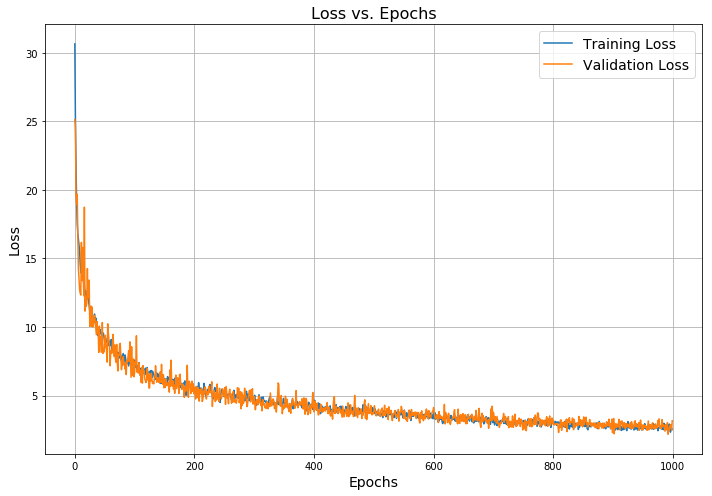

In [11]:
# Visualize the training process
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(train_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set_title('Loss vs. Epochs', fontsize=16)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)
plt.tight_layout()
plt.show()